### Stochastic Gradient Descent (SGD)

First, in the context of deep learning and this book, we call slices of data batches, where, 
historically, the term to refer to slices of data in the context of Stochastic Gradient Descent was 
mini-batches. In our context, it does not matter if the batch contains a single sample, a slice of 
the dataset, or the full dataset — as a batch of the data. Additionally, with the current code, we are 
fitting the full dataset; following this naming convention, we would use Batch Gradient Descent. 
In a future chapter, we’ll introduce data slices, or batches, so we should start by using the Minibatch Gradient Descent optimizer. That said, current naming trends and conventions with 
Stochastic Gradient Descent in use with deep learning today have merged and normalized all of 
these variants, to the point where we think of the Stochastic Gradient Descent optimizer as one 
that assumes a batch of data, whether that batch happens to be a single sample, every sample in a 
dataset, or some subset of the full dataset at a time.

In [39]:
class Optimizer_SGD:
    
    # Initialize optimizer - set settings, learning rate of 1.0 is default for this optimizer
    def __init__(self, learning_rate = 1.0):
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

Now Add this after the backward portion in the code

In [4]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

In [5]:
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        
        self.dinputs = np.dot(dvalues, self.weights.T)

In [6]:
class Activation_ReLU:
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [7]:
class Activation_Softmax:
    
    def forward(self, inputs):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_davlues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1,1)
            
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            
            # Calculate Sample-wise gradient
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [8]:
class Loss:
    
    def calculate(self,output, y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [9]:
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target classes
        # If sparse labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
            
        # If one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis = 1)
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        # If labels are sparse turn them into one-hot encoded vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

In [10]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        # If labels are one-hot encoded turn then into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

### Create  Dataset

In [11]:
X, y = spiral_data(samples=100, classes=3)

In [12]:
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [13]:
optimizer = Optimizer_SGD()

In [14]:
# Forward pass
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output,y)

print('loss: ',loss)

predictions = np.argmax(loss_activation.output, axis = 1)
if len(y.shape) == 2:
    y = np.argmax(y, axis = 1)
accuracy = np.mean(predictions == y)
print('acc: ', accuracy)

loss:  1.0985943
acc:  0.36


In [15]:
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

In [16]:
# Update weights and biases
optimizer.update_params(dense1)
optimizer.update_params(dense2)

This is everything we need to train our model! But why would we only perform this optimization 
once, when we can perform it lots of times by leveraging Python’s looping capabilities? We will 
repeatedly perform a forward pass, backward pass, and optimization until we reach some stopping 
point. Each full pass through all of the training data is called an epoch.

To add multiple 
epochs of training into our code, we will initialize our model and run a loop around all the code 
performing the forward pass, backward pass, and optimization calculations:

### Create  Dataset

In [17]:
X, y = spiral_data(samples=100, classes=3)

In [18]:
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD()
ep = []
l = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    ep.append(epoch)
    l.append(loss)
plt.plot(ep,l)
plt.show()

epoch: 0, acc: 0.343, loss: 1.099, 
epoch: 100, acc: 0.407, loss: 1.083, 
epoch: 200, acc: 0.397, loss: 1.071, 
epoch: 300, acc: 0.410, loss: 1.070, 
epoch: 400, acc: 0.410, loss: 1.069, 
epoch: 500, acc: 0.413, loss: 1.067, 
epoch: 600, acc: 0.410, loss: 1.064, 
epoch: 700, acc: 0.423, loss: 1.058, 
epoch: 800, acc: 0.450, loss: 1.047, 
epoch: 900, acc: 0.430, loss: 1.050, 
epoch: 1000, acc: 0.427, loss: 1.045, 
epoch: 1100, acc: 0.440, loss: 1.038, 
epoch: 1200, acc: 0.453, loss: 1.029, 
epoch: 1300, acc: 0.400, loss: 1.019, 
epoch: 1400, acc: 0.480, loss: 1.026, 
epoch: 1500, acc: 0.413, loss: 1.003, 
epoch: 1600, acc: 0.397, loss: 0.994, 
epoch: 1700, acc: 0.443, loss: 0.976, 
epoch: 1800, acc: 0.403, loss: 0.995, 
epoch: 1900, acc: 0.463, loss: 0.973, 
epoch: 2000, acc: 0.487, loss: 0.969, 
epoch: 2100, acc: 0.470, loss: 0.956, 
epoch: 2200, acc: 0.497, loss: 0.951, 
epoch: 2300, acc: 0.480, loss: 0.936, 
epoch: 2400, acc: 0.470, loss: 0.915, 
epoch: 2500, acc: 0.493, loss: 0.904,

NameError: name 'plt' is not defined

What if we make the learning rate 0.85 rather than 1.0 with the SGD optimizer?

In [20]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(learning_rate = 0.85)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
plt.plot(ep,l)
plt.show()

epoch: 0, acc: 0.390, loss: 1.099, 
epoch: 100, acc: 0.390, loss: 1.088, 
epoch: 200, acc: 0.400, loss: 1.071, 
epoch: 300, acc: 0.407, loss: 1.070, 
epoch: 400, acc: 0.407, loss: 1.069, 
epoch: 500, acc: 0.400, loss: 1.068, 
epoch: 600, acc: 0.413, loss: 1.067, 
epoch: 700, acc: 0.420, loss: 1.065, 
epoch: 800, acc: 0.420, loss: 1.063, 
epoch: 900, acc: 0.443, loss: 1.059, 
epoch: 1000, acc: 0.450, loss: 1.054, 
epoch: 1100, acc: 0.470, loss: 1.046, 
epoch: 1200, acc: 0.400, loss: 1.055, 
epoch: 1300, acc: 0.407, loss: 1.054, 
epoch: 1400, acc: 0.403, loss: 1.052, 
epoch: 1500, acc: 0.400, loss: 1.053, 
epoch: 1600, acc: 0.410, loss: 1.052, 
epoch: 1700, acc: 0.417, loss: 1.091, 
epoch: 1800, acc: 0.397, loss: 1.054, 
epoch: 1900, acc: 0.460, loss: 1.048, 


KeyboardInterrupt: 

### Learning Rate Decay

In [21]:
starting_learning_rate = 1.0
learning_rate_decay = 0.1
step = 1

learning_rate = starting_learning_rate * (1.0 / (1+ learning_rate_decay * step))
print(learning_rate)

0.9090909090909091


In practice, 0.1 would be considered a fairly aggressive decay rate, but this should give you a 
sense of the concept. If we are on step 20:

In [22]:
starting_learning_rate = 1.
learning_rate_decay = 0.1
step = 20

learning_rate = starting_learning_rate * \
                (1. / (1 + learning_rate_decay * step))
print(learning_rate)

0.3333333333333333


We can also simulate this in a loop, which is more comparable to how we will be applying 
learning rate decay:

In [23]:
starting_learning_rate = 1.
learning_rate_decay = 0.1

for step in range(21):
    learning_rate = starting_learning_rate * (1. / (1 + learning_rate_decay * step))
    print(learning_rate)

1.0
0.9090909090909091
0.8333333333333334
0.7692307692307692
0.7142857142857143
0.6666666666666666
0.625
0.588235294117647
0.5555555555555556
0.5263157894736842
0.5
0.47619047619047616
0.45454545454545453
0.4347826086956522
0.41666666666666663
0.4
0.3846153846153846
0.37037037037037035
0.35714285714285715
0.3448275862068965
0.3333333333333333


We can now update our SGD optimizer 
class to allow for the learning rate decay:

In [24]:
class Optimizer_SGD:
    
    def __init__(self, learning_rate=1., decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        
    # Call once before any parameter updates\
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
                 
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases
    
    # Call once any parameter updates
    def post_update_params(self):
        self.iterations += 1

 Let’s use a decay rate of 1e-2 (0.01) and train our model again

epoch: 0, acc: 0.283, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.410, loss: 1.094, lr: 0.5025125628140703
epoch: 200, acc: 0.403, loss: 1.079, lr: 0.33444816053511706
epoch: 300, acc: 0.413, loss: 1.073, lr: 0.2506265664160401
epoch: 400, acc: 0.400, loss: 1.071, lr: 0.2004008016032064
epoch: 500, acc: 0.400, loss: 1.070, lr: 0.1669449081803005
epoch: 600, acc: 0.407, loss: 1.070, lr: 0.14306151645207438
epoch: 700, acc: 0.407, loss: 1.070, lr: 0.1251564455569462
epoch: 800, acc: 0.407, loss: 1.070, lr: 0.11123470522803114
epoch: 900, acc: 0.410, loss: 1.070, lr: 0.10010010010010009
epoch: 1000, acc: 0.413, loss: 1.070, lr: 0.09099181073703366
epoch: 1100, acc: 0.413, loss: 1.070, lr: 0.08340283569641367
epoch: 1200, acc: 0.413, loss: 1.069, lr: 0.07698229407236336
epoch: 1300, acc: 0.413, loss: 1.069, lr: 0.07147962830593281
epoch: 1400, acc: 0.413, loss: 1.069, lr: 0.066711140760507
epoch: 1500, acc: 0.413, loss: 1.069, lr: 0.06253908692933083
epoch: 1600, acc: 0.413, loss: 1.069, lr: 0

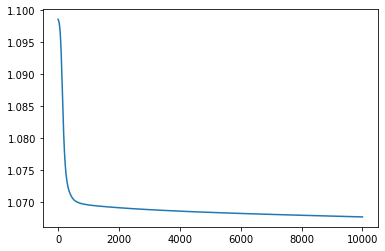

In [21]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay = 1e-2)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

This model definitely got stuck, and the reason is almost certainly because the learning rate 
decayed far too quickly and became too small, trapping the model in some local minimum. This is 
most likely why, rather than wiggling, our accuracy and loss stopped changing at all.
We can, instead, try to decay a bit slower by making our decay a smaller number. For example, 
let’s go with 1e-3 (0.001):

epoch: 0, acc: 0.390, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.393, loss: 1.083, lr: 0.9099181073703367
epoch: 200, acc: 0.400, loss: 1.071, lr: 0.8340283569641367
epoch: 300, acc: 0.407, loss: 1.070, lr: 0.7698229407236336
epoch: 400, acc: 0.407, loss: 1.069, lr: 0.7147962830593281
epoch: 500, acc: 0.400, loss: 1.068, lr: 0.66711140760507
epoch: 600, acc: 0.407, loss: 1.067, lr: 0.6253908692933083
epoch: 700, acc: 0.417, loss: 1.066, lr: 0.5885815185403178
epoch: 800, acc: 0.420, loss: 1.065, lr: 0.5558643690939411
epoch: 900, acc: 0.417, loss: 1.063, lr: 0.526592943654555
epoch: 1000, acc: 0.423, loss: 1.061, lr: 0.5002501250625312
epoch: 1100, acc: 0.437, loss: 1.057, lr: 0.4764173415912339
epoch: 1200, acc: 0.443, loss: 1.053, lr: 0.45475216007276037
epoch: 1300, acc: 0.450, loss: 1.048, lr: 0.43497172683775553
epoch: 1400, acc: 0.480, loss: 1.041, lr: 0.4168403501458941
epoch: 1500, acc: 0.503, loss: 1.035, lr: 0.4001600640256102
epoch: 1600, acc: 0.517, loss: 1.027, lr: 0.38476337

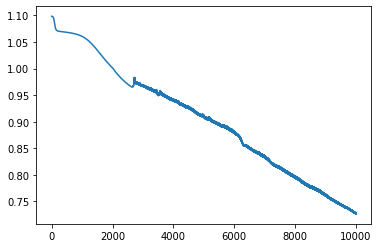

In [22]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay = 1e-3)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

#### Stochastic Gradient Descent with Momentum

In [25]:
class Optimizer_SGD:
    
    def __init__(self, learning_rate = 1.0, decay = 0.0, momentum = 0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self. momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))
            
    def update_params(self, layer):
        
        # If we use momentum
        if self.momentum:
        # If layer does not contain momentum arrays, create them filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights the array doesn't exist for biases yet either
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradient
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            # Build bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
        
        
    def post_update_params(self):
        self.iterations += 1

Let’s show an example illustrating how adding momentum changes the learning process. Keeping 
the same starting learning rate (1) and decay (1e-3) from the previous training attempt and using 
a momentum of 0.5:

epoch: 0, acc: 0.300, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.403, loss: 1.072, lr: 0.9099181073703367
epoch: 200, acc: 0.397, loss: 1.068, lr: 0.8340283569641367
epoch: 300, acc: 0.400, loss: 1.065, lr: 0.7698229407236336
epoch: 400, acc: 0.430, loss: 1.055, lr: 0.7147962830593281
epoch: 500, acc: 0.450, loss: 1.038, lr: 0.66711140760507
epoch: 600, acc: 0.543, loss: 1.016, lr: 0.6253908692933083
epoch: 700, acc: 0.517, loss: 1.012, lr: 0.5885815185403178
epoch: 800, acc: 0.503, loss: 1.003, lr: 0.5558643690939411
epoch: 900, acc: 0.543, loss: 0.985, lr: 0.526592943654555
epoch: 1000, acc: 0.537, loss: 0.969, lr: 0.5002501250625312
epoch: 1100, acc: 0.533, loss: 0.954, lr: 0.4764173415912339
epoch: 1200, acc: 0.537, loss: 0.944, lr: 0.45475216007276037
epoch: 1300, acc: 0.543, loss: 0.933, lr: 0.43497172683775553
epoch: 1400, acc: 0.550, loss: 0.922, lr: 0.4168403501458941
epoch: 1500, acc: 0.557, loss: 0.912, lr: 0.4001600640256102
epoch: 1600, acc: 0.550, loss: 0.905, lr: 0.38476337

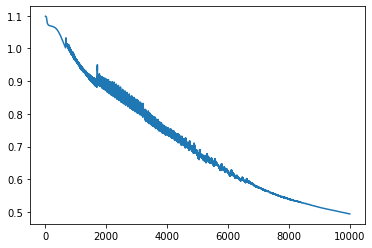

In [24]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay = 1e-3, momentum = 0.5)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

The model achieved the lowest loss and highest accuracy that we’ve seen so far, but can we do 
even better? Sure we can! Let’s try to set the momentum to 0.8:

epoch: 0, acc: 0.297, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.407, loss: 1.068, lr: 0.9099181073703367
epoch: 200, acc: 0.447, loss: 1.044, lr: 0.8340283569641367
epoch: 300, acc: 0.553, loss: 0.971, lr: 0.7698229407236336
epoch: 400, acc: 0.473, loss: 0.977, lr: 0.7147962830593281
epoch: 500, acc: 0.507, loss: 0.922, lr: 0.66711140760507
epoch: 600, acc: 0.593, loss: 0.821, lr: 0.6253908692933083
epoch: 700, acc: 0.620, loss: 0.796, lr: 0.5885815185403178
epoch: 800, acc: 0.677, loss: 0.728, lr: 0.5558643690939411
epoch: 900, acc: 0.697, loss: 0.690, lr: 0.526592943654555
epoch: 1000, acc: 0.747, loss: 0.597, lr: 0.5002501250625312
epoch: 1100, acc: 0.730, loss: 0.600, lr: 0.4764173415912339
epoch: 1200, acc: 0.747, loss: 0.592, lr: 0.45475216007276037
epoch: 1300, acc: 0.787, loss: 0.493, lr: 0.43497172683775553
epoch: 1400, acc: 0.817, loss: 0.472, lr: 0.4168403501458941
epoch: 1500, acc: 0.803, loss: 0.438, lr: 0.4001600640256102
epoch: 1600, acc: 0.817, loss: 0.440, lr: 0.38476337

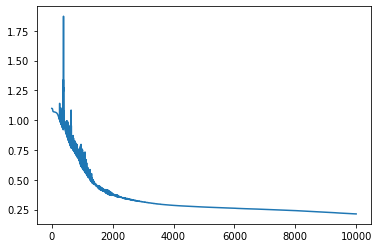

In [105]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_SGD(decay = 1e-3, momentum = 0.8)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

### AdaGrad

AdaGrad, short for adaptive gradient, institutes a per-parameter learning rate rather than a 
globally-shared rate. The idea here is to normalize updates made to the features. During the 
training process, some weights can rise significantly, while others tend to not change by much. 
It is usually better for weights to not rise too high compared to the other weights, and we’ll talk 
about this with regularization techniques. AdaGrad provides a way to normalize parameter updates 
by keeping a history of previous updates — the bigger the sum of the updates is, in either direction 
(positive or negative), the smaller updates are made further in training. This lets less-frequently 
updated parameters to keep-up with changes, effectively utilizing more neurons for training.

In [26]:
class Optimizer_Adagrad:
    
    def __init__(self, learning_rate = 1.0, decay = 0.0, epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

Testing this optimizer now with decaying set to 1e-4 as well as 1e-5 works better than 1e-3, which 
we have used previously. This optimizer with our dataset works better with lesser decaying:

epoch: 0, acc: 0.320, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.447, loss: 1.038, lr: 0.9901970492127933
epoch: 200, acc: 0.487, loss: 1.024, lr: 0.9804882831650161
epoch: 300, acc: 0.513, loss: 1.019, lr: 0.9709680551509855
epoch: 400, acc: 0.527, loss: 1.012, lr: 0.9616309260505818
epoch: 500, acc: 0.523, loss: 1.006, lr: 0.9524716639679969
epoch: 600, acc: 0.520, loss: 1.000, lr: 0.9434852344560807
epoch: 700, acc: 0.527, loss: 0.992, lr: 0.9346667912889054
epoch: 800, acc: 0.523, loss: 0.988, lr: 0.9260116677470135
epoch: 900, acc: 0.513, loss: 0.982, lr: 0.9175153683824203
epoch: 1000, acc: 0.500, loss: 0.974, lr: 0.9091735612328392
epoch: 1100, acc: 0.517, loss: 0.958, lr: 0.9009820704567978
epoch: 1200, acc: 0.517, loss: 0.970, lr: 0.892936869363336
epoch: 1300, acc: 0.517, loss: 0.962, lr: 0.8850340738118416
epoch: 1400, acc: 0.523, loss: 0.957, lr: 0.8772699359592947
epoch: 1500, acc: 0.523, loss: 0.952, lr: 0.8696408383337683
epoch: 1600, acc: 0.533, loss: 0.945, lr: 0.86214328

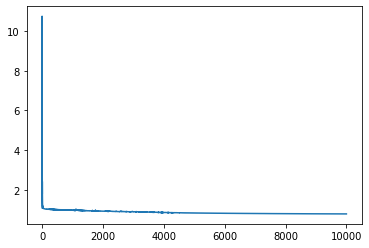

In [26]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adagrad(decay = 1e-4)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

### RMSProp

Continuing with Stochastic Gradient Descent adaptations, we reach RMSProp, short for Root 
Mean Square Propagation. Similar to AdaGrad, RMSProp calculates an adaptive learning rate 
per parameter; it’s just calculated in a different way than AdaGrad.

`cache = rho * cache + (1 - rho) * gradient ** 2`

Note that this is similar to both momentum with the SGD optimizer and cache with the AdaGrad. 
RMSProp adds a mechanism similar to momentum but also adds a per-parameter adaptive 
learning rate, so the learning rate changes are smoother.

In [39]:
class Optimizer_RMSprop:
    
    def __init__(self, learning_rate = 0.001, decay = 0.0, epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))
    
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

Changing the optimizer used in our main neural network testing code

epoch: 0, acc: 0.327, loss: 1.099, lr: 0.001
epoch: 100, acc: 0.407, loss: 1.073, lr: 0.0009901970492127933
epoch: 200, acc: 0.413, loss: 1.066, lr: 0.0009804882831650162
epoch: 300, acc: 0.427, loss: 1.059, lr: 0.0009709680551509856
epoch: 400, acc: 0.463, loss: 1.049, lr: 0.0009616309260505818
epoch: 500, acc: 0.523, loss: 1.037, lr: 0.0009524716639679969
epoch: 600, acc: 0.530, loss: 1.024, lr: 0.0009434852344560807
epoch: 700, acc: 0.537, loss: 1.011, lr: 0.0009346667912889054
epoch: 800, acc: 0.523, loss: 0.999, lr: 0.0009260116677470135
epoch: 900, acc: 0.507, loss: 0.986, lr: 0.0009175153683824203
epoch: 1000, acc: 0.523, loss: 0.974, lr: 0.0009091735612328393
epoch: 1100, acc: 0.537, loss: 0.962, lr: 0.0009009820704567978
epoch: 1200, acc: 0.543, loss: 0.951, lr: 0.0008929368693633361
epoch: 1300, acc: 0.560, loss: 0.939, lr: 0.0008850340738118417
epoch: 1400, acc: 0.573, loss: 0.928, lr: 0.0008772699359592947
epoch: 1500, acc: 0.570, loss: 0.918, lr: 0.0008696408383337683
epoc

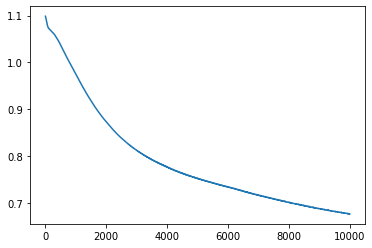

In [29]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_RMSprop(decay = 1e-4)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

The results are not the greatest, but we can slightly tweak the hyperparameters:

epoch: 0, acc: 0.347, loss: 1.099, lr: 0.01
epoch: 100, acc: 0.420, loss: 0.989, lr: 0.009901970492127933
epoch: 200, acc: 0.460, loss: 0.930, lr: 0.009804882831650161
epoch: 300, acc: 0.543, loss: 0.903, lr: 0.009709680551509855
epoch: 400, acc: 0.533, loss: 0.873, lr: 0.009616309260505818
epoch: 500, acc: 0.550, loss: 0.854, lr: 0.00952471663967997
epoch: 600, acc: 0.530, loss: 0.841, lr: 0.009434852344560807
epoch: 700, acc: 0.563, loss: 0.829, lr: 0.009346667912889054
epoch: 800, acc: 0.540, loss: 0.819, lr: 0.009260116677470134
epoch: 900, acc: 0.537, loss: 0.812, lr: 0.009175153683824204
epoch: 1000, acc: 0.553, loss: 0.802, lr: 0.009091735612328393
epoch: 1100, acc: 0.577, loss: 0.793, lr: 0.009009820704567979
epoch: 1200, acc: 0.590, loss: 0.779, lr: 0.00892936869363336
epoch: 1300, acc: 0.590, loss: 0.774, lr: 0.008850340738118417
epoch: 1400, acc: 0.613, loss: 0.767, lr: 0.008772699359592948
epoch: 1500, acc: 0.597, loss: 0.764, lr: 0.008696408383337682
epoch: 1600, acc: 0.62

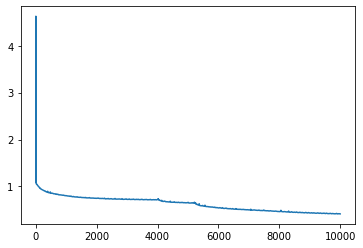

In [37]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_RMSprop(learning_rate = 0.01, decay = 1e-4, rho = 0.999)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

### Adam

In [41]:
class Optimizer_Adam:
    
    def __init__(self, learning_rate = 0.001, decay = 0.0, epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * \
        layer.weight_momentums + \
        (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
        layer.bias_momentums + \
        (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / \
        (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
        (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
        (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
        (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / \
        (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
        (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * \
        weight_momentums_corrected / \
        (np.sqrt(weight_cache_corrected) +
        self.epsilon)
        layer.biases += -self.current_learning_rate * \
        bias_momentums_corrected / \
        (np.sqrt(bias_cache_corrected) +
        self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

Back to our main neural network code. We can now set our optimizer to Adam, run the code, and 
see what impact these changes had:

epoch: 0, acc: 0.240, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.587, loss: 0.919, lr: 0.019803940984255867
epoch: 200, acc: 0.713, loss: 0.682, lr: 0.019609765663300322
epoch: 300, acc: 0.750, loss: 0.570, lr: 0.01941936110301971
epoch: 400, acc: 0.743, loss: 0.527, lr: 0.019232618521011637
epoch: 500, acc: 0.807, loss: 0.472, lr: 0.01904943327935994
epoch: 600, acc: 0.840, loss: 0.440, lr: 0.018869704689121615
epoch: 700, acc: 0.820, loss: 0.416, lr: 0.018693335825778108
epoch: 800, acc: 0.837, loss: 0.398, lr: 0.01852023335494027
epoch: 900, acc: 0.843, loss: 0.374, lr: 0.018350307367648408
epoch: 1000, acc: 0.843, loss: 0.360, lr: 0.018183471224656786
epoch: 1100, acc: 0.860, loss: 0.341, lr: 0.018019641409135957
epoch: 1200, acc: 0.857, loss: 0.326, lr: 0.01785873738726672
epoch: 1300, acc: 0.883, loss: 0.314, lr: 0.017700681476236834
epoch: 1400, acc: 0.883, loss: 0.301, lr: 0.017545398719185895
epoch: 1500, acc: 0.863, loss: 0.295, lr: 0.017392816766675364
epoch: 1600, acc: 0.897,

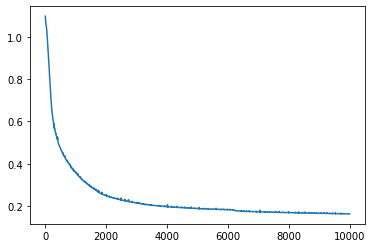

In [59]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate = 0.02, decay = 1e-4)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

This is the best result so far, but let’s adjust the learning rate to be a bit higher, to 0.05 and change 
decay to 5e-7:

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.630, loss: 0.836, lr: 0.04999752512250644
epoch: 200, acc: 0.723, loss: 0.697, lr: 0.04999502549496326
epoch: 300, acc: 0.780, loss: 0.604, lr: 0.049992526117345455
epoch: 400, acc: 0.843, loss: 0.523, lr: 0.04999002698961558
epoch: 500, acc: 0.833, loss: 0.476, lr: 0.049987528111736124
epoch: 600, acc: 0.847, loss: 0.437, lr: 0.049985029483669646
epoch: 700, acc: 0.857, loss: 0.401, lr: 0.049982531105378675
epoch: 800, acc: 0.860, loss: 0.386, lr: 0.04998003297682575
epoch: 900, acc: 0.873, loss: 0.367, lr: 0.049977535097973466
epoch: 1000, acc: 0.887, loss: 0.352, lr: 0.049975037468784345
epoch: 1100, acc: 0.867, loss: 0.343, lr: 0.049972540089220974
epoch: 1200, acc: 0.887, loss: 0.334, lr: 0.04997004295924593
epoch: 1300, acc: 0.870, loss: 0.326, lr: 0.04996754607882181
epoch: 1400, acc: 0.880, loss: 0.329, lr: 0.049965049447911185
epoch: 1500, acc: 0.883, loss: 0.314, lr: 0.04996255306647668
epoch: 1600, acc: 0.867, lo

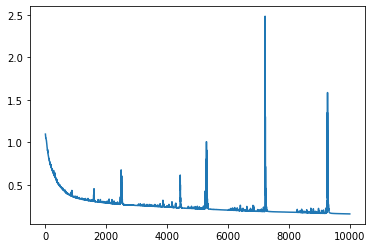

In [44]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate = 0.05, decay = 5e-7)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

### Full code up to this point:

In [4]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [43]:
# Dense Layer
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        
        self.dinputs = np.dot(dvalues, self.weights.T)

In [6]:
# ReLU Activtion
class Activation_ReLU:
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [23]:
# Softmax Activation
class Activation_Softmax:
    
    def forward(self, inputs):
        self.inputs = inputs
        
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        
        self.output = probabilities
        
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(signle_output) - np.dot(single_output, single_input.T)
            
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)


In [8]:
# SGD Optimizer
class Optimizer_SGD:
    
    def __init__(self, learning_rate = 1.0, decay = 0.0, momentum = 0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
                
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates  = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbaises
            
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    
    def post_params(self):
        self.iterations += 1

In [9]:
# Adagrad Optimizer
class Optimizer_Adagrad:
    
    def __init__(self, learning_rate = 1.0, decay = 0.0, epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
    
    
    def update_params(self,layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbaises**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bais_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

In [10]:
# RMSprop optimizer
class Optimizer_RMSprop:
    
    def __init__(self, learning_rate = 0.001, decay = 0.0, epsilon = 1e-7, rho = 0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bais_cache =  np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -slef.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

In [36]:
class Optimizer_Adam:
    
    def __init__(self, learning_rate = 0.001, decay = 0.0, epsilon = 1e-7, beta_1 = 0.9, beta_2 = 0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1 * \
        layer.weight_momentums + \
        (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
        layer.bias_momentums + \
        (1 - self.beta_1) * layer.dbiases
        
        weight_momentums_corrected = layer.weight_momentums / \
        (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
        (1 - self.beta_1 ** (self.iterations + 1))
        
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
        (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
        (1 - self.beta_2) * layer.dbiases**2
        
        weight_cache_corrected = layer.weight_cache / \
        (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
        (1 - self.beta_2 ** (self.iterations + 1))
        
        layer.weights += -self.current_learning_rate * \
        weight_momentums_corrected / \
        (np.sqrt(weight_cache_corrected) +
        self.epsilon)
        layer.biases += -self.current_learning_rate * \
        bias_momentums_corrected / \
        (np.sqrt(bias_cache_corrected) +
        self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1

In [12]:
# Common Loss Class
class Loss:
    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [13]:
# Cross-Entropy Loss
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis = 1
            )
            
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        lables = len(dvalues)
        
        if len(y_true.shape) == 1:
            y_true = np.eye(lables)[y_true]
            
        self.dinputs = - y_true / dvalues
        self.dinputs = self.dinputs / samples

In [15]:
# Softmax And Cross-entropy combined for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true) == 2:
            y_true = np.argmax(y_true, axis = 1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

### Create Dataset

epoch: 0, acc: 0.320, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.647, loss: 0.791, lr: 0.04999901001960161
epoch: 200, acc: 0.723, loss: 0.591, lr: 0.04999801007919885
epoch: 300, acc: 0.767, loss: 0.504, lr: 0.04999701017879131
epoch: 400, acc: 0.787, loss: 0.463, lr: 0.049996010318376596
epoch: 500, acc: 0.793, loss: 0.429, lr: 0.0499950104979523
epoch: 600, acc: 0.830, loss: 0.401, lr: 0.049994010717516045
epoch: 700, acc: 0.820, loss: 0.383, lr: 0.04999301097706541
epoch: 800, acc: 0.840, loss: 0.355, lr: 0.049992011276598
epoch: 900, acc: 0.833, loss: 0.347, lr: 0.04999101161611143
epoch: 1000, acc: 0.873, loss: 0.336, lr: 0.049990011995603274
epoch: 1100, acc: 0.877, loss: 0.321, lr: 0.04998901241507117
epoch: 1200, acc: 0.883, loss: 0.298, lr: 0.049988012874512704
epoch: 1300, acc: 0.887, loss: 0.298, lr: 0.04998701337392546
epoch: 1400, acc: 0.873, loss: 0.285, lr: 0.049986013913307065
epoch: 1500, acc: 0.887, loss: 0.280, lr: 0.049985014492655105
epoch: 1600, acc: 0.887, loss: 0

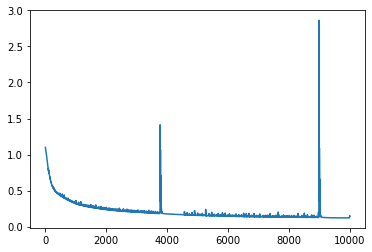

In [52]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate = 0.05, decay = 2e-7)
l = []
ep = []
# Train in loop
for epoch in range(10001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()

In [49]:
class Activation_SQRT:
    def forward(self, inputs):
        self.inputs = inputs
        self.abs_ = np.abs(inputs)
        self.output = self.abs_
        
    def backward(self, dvalues):
#         dsqrt = 1 / (2 * np.sqrt(self.abs_) + 1e-7)
        dabs = np.where(self.inputs!=0,self.inputs / self.abs_,0)
        self.dinputs = dabs * dvalues

epoch: 0, acc: 0.333, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.657, loss: 0.814, lr: 0.04999752512250644
epoch: 200, acc: 0.733, loss: 0.706, lr: 0.04999502549496326


<ipython-input-49-ae0c223f2f0c>:9: RuntimeWarning: invalid value encountered in divide
  dabs = np.where(self.inputs!=0,self.inputs / self.abs_,0)


epoch: 300, acc: 0.760, loss: 0.640, lr: 0.049992526117345455
epoch: 400, acc: 0.797, loss: 0.584, lr: 0.04999002698961558
epoch: 500, acc: 0.817, loss: 0.524, lr: 0.049987528111736124
epoch: 600, acc: 0.817, loss: 0.496, lr: 0.049985029483669646
epoch: 700, acc: 0.837, loss: 0.474, lr: 0.049982531105378675
epoch: 800, acc: 0.767, loss: 0.476, lr: 0.04998003297682575
epoch: 900, acc: 0.773, loss: 0.466, lr: 0.049977535097973466
epoch: 1000, acc: 0.803, loss: 0.434, lr: 0.049975037468784345
epoch: 1100, acc: 0.840, loss: 0.393, lr: 0.049972540089220974
epoch: 1200, acc: 0.867, loss: 0.365, lr: 0.04997004295924593
epoch: 1300, acc: 0.867, loss: 0.365, lr: 0.04996754607882181
epoch: 1400, acc: 0.857, loss: 0.364, lr: 0.049965049447911185
epoch: 1500, acc: 0.860, loss: 0.356, lr: 0.04996255306647668
epoch: 1600, acc: 0.880, loss: 0.325, lr: 0.049960056934480884
epoch: 1700, acc: 0.893, loss: 0.313, lr: 0.04995756105188642
epoch: 1800, acc: 0.867, loss: 0.311, lr: 0.049955065418655915
epoch

epoch: 13700, acc: 0.903, loss: 0.215, lr: 0.04965985482438041
epoch: 13800, acc: 0.903, loss: 0.204, lr: 0.04965738884565937
epoch: 13900, acc: 0.900, loss: 0.212, lr: 0.04965492311183431
epoch: 14000, acc: 0.897, loss: 0.200, lr: 0.04965245762286873
epoch: 14100, acc: 0.900, loss: 0.203, lr: 0.04964999237872617
epoch: 14200, acc: 0.910, loss: 0.206, lr: 0.049647527379370164
epoch: 14300, acc: 0.897, loss: 0.213, lr: 0.04964506262476426
epoch: 14400, acc: 0.903, loss: 0.208, lr: 0.04964259811487198
epoch: 14500, acc: 0.900, loss: 0.207, lr: 0.04964013384965692
epoch: 14600, acc: 0.897, loss: 0.199, lr: 0.04963766982908261
epoch: 14700, acc: 0.910, loss: 0.208, lr: 0.049635206053112654
epoch: 14800, acc: 0.900, loss: 0.210, lr: 0.049632742521710606
epoch: 14900, acc: 0.923, loss: 0.204, lr: 0.049630279234840056
epoch: 15000, acc: 0.917, loss: 0.205, lr: 0.04962781619246462
epoch: 15100, acc: 0.923, loss: 0.202, lr: 0.04962535339454786
epoch: 15200, acc: 0.917, loss: 0.203, lr: 0.049622

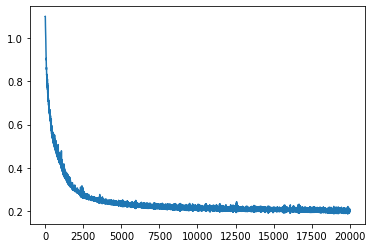

In [51]:
import matplotlib.pyplot as plt
dense1 = Layer_Dense(2,64)
activation1 = Activation_SQRT()
dense2 = Layer_Dense(64,3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate = 0.05, decay = 5e-7)
l = []
ep = []
# Train in loop
for epoch in range(20001):
    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output,y)

    predictions = np.argmax(loss_activation.output, axis = 1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis = 1)
    accuracy = np.mean(predictions == y)
    ep.append(epoch)
    l.append(loss)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' + 
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}, ' + 
              f'lr: {optimizer.current_learning_rate}')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
plt.plot(ep,l)
plt.show()